In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

In [10]:
raw_data = pd.read_csv('../data/ENB2012_data.csv')

# Orientation as a numeric or categorical parameter?

Remember from EDA part (part1) that the data in 'Orientation' column is consist of integers. It would be considered a litle bit suspicious since the orientation of a building is not a direct physical measure (like height). One can claim that it can be considered as categorical. Hence, we can compare the performance of each option with a simple modeling trial. We will also need a comparison for the logarithm function options of target variables. Hence, let's define a basic assessment function for convenience:

In [11]:
def assessment(df, log_func=None):
    X = df.iloc[:,0:-2]
    y = df[['heating', 'cooling']]

    #Let's devide the original data to two parts (70:30) for early experimentation:
    X_train_df, X_val_df, y_train, y_val = train_test_split(X, y, test_size = 0.30, random_state = 155)

    # Deploy hte dictionary vectorizer
    dv = DictVectorizer(sparse=False)

    X_train_df = X_train_df.reset_index(drop=True)
    X_train_dict = X_train_df.to_dict(orient='records')
    X_train = dv.fit_transform(X_train_dict)

    X_val_df = X_val_df.reset_index(drop=True)
    X_val_dict = X_val_df.to_dict(orient='records')
    X_val = dv.fit_transform(X_val_dict)

    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    dt =DecisionTreeRegressor(random_state=155)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_val)

    r2 = np.mean(r2_score(y_val, y_pred))
    rmse= np.sqrt(mean_squared_error(y_val,y_pred))
    print(f"r2 score: {r2.round(5)}   RMSE: {rmse.round(3)}")

    coef = pd.Series(dt.feature_importances_, dv.get_feature_names()).sort_values(ascending=False)
    coef.plot(kind='bar', title="Feature Importance")
    plt.show()

In [12]:
df_numeric = raw_data.copy()  # keep the raw data as original

df_categorical = raw_data.copy()  # keep the raw data as original

# Define conversion rules:
mapping1 = {
    2:'orient2',
    3:'orient3',
    4:'orient4',
    5:'orient5'}

df_categorical.orientation = df_categorical.orientation.map(mapping1)

Performance of numeric option: 
r2 score: 0.97636   RMSE: 1.491


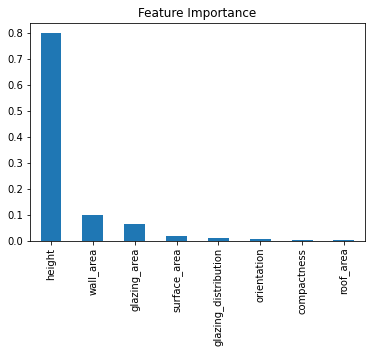

Performance of categoricic option: 
r2 score: 0.97404   RMSE: 1.562


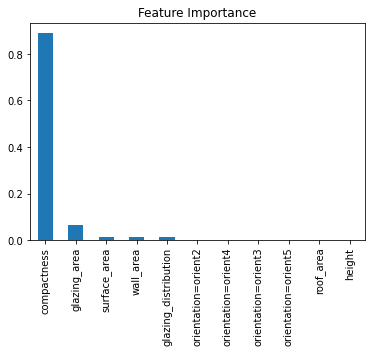

In [13]:
print("Performance of numeric option: ")
assessment(df_numeric)
print("Performance of categoricic option: ")
assessment(df_categorical)


Comparing the performance difference among the datasets with numeric and categoric versions of the 'orientation' column, the numeric option is better. It seems that dividing the column to 4 parts eliminates its already limited importance. Hence, keep the 'orientation' column in the original form (numeric). Remember that the orientation of a building determine the incoming sunlight angles on facades that results in variations in energy balance of a building. In other words, it can definitely be considered as a physical measure. 

# Log Function For Target Variables

Remember from part1 that the target variables (heating and cooling loads) are highly skewed. A practical way to overcome this is to use their log values. MOreover, the feature matrices with high number of zeros, log+1 approach is also an option. Let's compare each option:

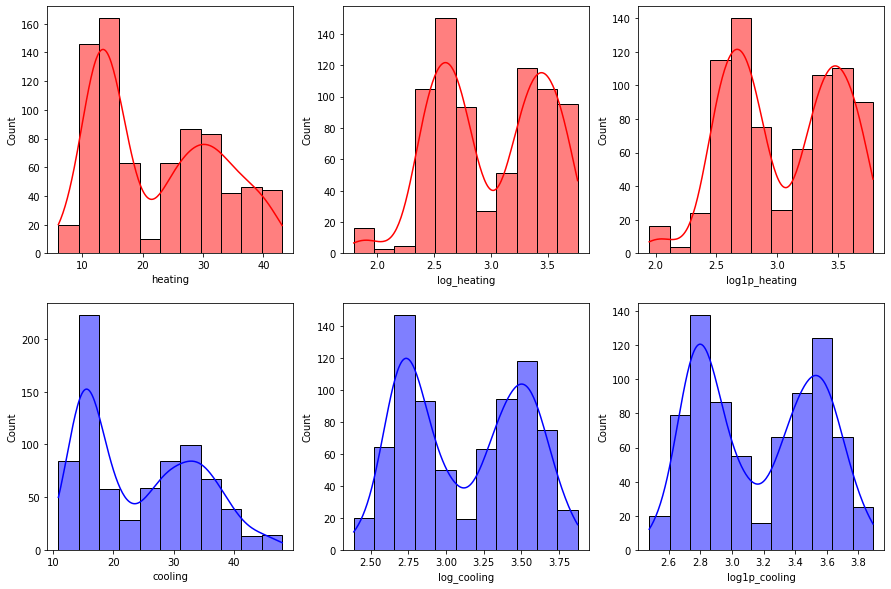

In [14]:
df = raw_data

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)

sns.histplot(df["heating"], kde=True, color='red')

plt.subplot(2,3,2)
df["log_heating"]=np.log(df["heating"])
sns.histplot(df["log_heating"], kde=True, color='red')

plt.subplot(2,3,3)
df["log1p_heating"]=np.log1p(df["heating"])
sns.histplot(df["log1p_heating"], kde=True, color='red')

plt.subplot(2,3,4)

sns.histplot(df["cooling"], kde=True, color='blue' )


plt.subplot(2,3,5)
df["log_cooling"]=np.log(df["cooling"])
sns.histplot(df["log_cooling"], kde=True, color='blue')

plt.subplot(2,3,6)
df["log1p_cooling"]=np.log1p(df["cooling"])
sns.histplot(df["log1p_cooling"], kde=True, color='blue')


plt.show()

Using log values prevents skewness in a certain level but note that the target variables don't have a normal distribution.

The log and log1p options have very similar distributions. Since our feature matrx doesn't involve zeros (or very very small numbers), let's pick the log option for nex steps.